In [1]:

import pandas as pd
import numpy as np
import re
import os
import glob
import bs4
import re
import sys
sys.path.append("../")
from scripts.oldlistings import get_oldlistings_page
import json
from tqdm import tqdm

In [2]:
import pandas as pd
import re
import numpy as np

def process_df(data_df):
    def find_meta(xs, label, default=None, conversion=lambda x: x):
        for x in xs:
            if x['label'] == label:
                return conversion(x['quantity'])
        return default

    pattern1 = r"\$(\d+)\s*(per week|pw)"
    pattern2 = r"\$(\d{3,4})"
    pattern3 = r"(\d{3,4})"

    data = data_df
    
    # extract rented prices to multiple rows
    pdf2 = pd.DataFrame(data['rented_prices'].to_list(), index=data.index).stack()
    pdf2 = pdf2.reset_index()
    pdf2.rename(columns={'level_0': 'index', 0: 'rented_price_dict'}, inplace=True)
    pdf2.drop(columns='level_1', inplace=True)
    pdf = pdf2.join(data, on='index', how='left')
    
    # meta data
    pdf['bed'] = pdf['meta_data'].apply(lambda xs: find_meta(xs, 'bed', 0, lambda x: float(x)))
    pdf['bath'] = pdf['meta_data'].apply(lambda xs: find_meta(xs, 'bath', 0, lambda x: float(x)))
    pdf['car'] = pdf['meta_data'].apply(lambda xs: find_meta(xs, 'car', 0, lambda x: float(x)))
    pdf['land'] = pdf['meta_data'].apply(lambda xs: find_meta(xs, 'land', np.nan, lambda x: str(x)))
    pdf['type'] = pdf['meta_data'].apply(lambda xs: find_meta(xs, 'type', "Unit/apmt"))
    
    pdf.drop(columns=['meta_data', 'rented_prices', 'index'], inplace=True)

    # Extract rented price to multiple columns using nested if-else (lambda with ternary conditions)
    pdf["rented_price"] = pdf["rented_price_dict"].apply(
        lambda x: re.search(pattern1, x['price']).group(1) if re.search(pattern1, x['price']) 
        else (re.search(pattern2, x['price']).group(0) if re.search(pattern2, x['price']) 
        else re.search(pattern3, x['price']).group(0) if re.search(pattern3, x['price']) else np.nan)
    )
    
    pdf["date"] = pdf["rented_price_dict"].apply(lambda x: x['date'])
    #pdf["date"] = pdf["date"].apply(lambda x: pd.to_datetime(x))
    
    return pdf


In [3]:
data_list = []
for i in range(1,6):
    template = f"../data/landing/oldlistings_rent_{i}.json"
    data_list.append(template)
    

In [6]:
for k in data_list:
    data = pd.read_json(k)
    labels = []
    for i in range(len(data)):
        for j in data.iloc[i]["meta_data"]:
            if j["label"] not in labels:
                labels.append(j["label"])
                print(labels)



['bed']
['bed', 'bath']
['bed', 'bath', 'car']
['bed', 'bath', 'car', 'land']
['bed', 'bath', 'car', 'land', 'type']
['bed']
['bed', 'bath']
['bed', 'bath', 'car']
['bed', 'bath', 'car', 'land']
['bed', 'bath', 'car', 'land', 'type']
['bed']
['bed', 'bath']
['bed', 'bath', 'car']
['bed', 'bath', 'car', 'type']
['bed', 'bath', 'car', 'type', 'land']
['bed']
['bed', 'bath']
['bed', 'bath', 'car']
['bed', 'bath', 'car', 'type']
['bed', 'bath', 'car', 'type', 'land']
['bed']
['bed', 'bath']
['bed', 'bath', 'car']
['bed', 'bath', 'car', 'type']
['bed', 'bath', 'car', 'type', 'land']


Merge all datasets into one dataset


In [6]:
data_list

['../data/landing/oldlistings_rent_1.json',
 '../data/landing/oldlistings_rent_2.json',
 '../data/landing/oldlistings_rent_3.json',
 '../data/landing/oldlistings_rent_4.json',
 '../data/landing/oldlistings_rent_5.json']

In [7]:
rental_df = pd.DataFrame()
for i in range(1,len(data_list)):
    data = pd.read_json(data_list[i])
    rental_df_x = process_df(data)
    rental_df = pd.concat([rental_df,rental_df_x],axis=0)




In [8]:
# find the data that has rented price is nan
rental_df[rental_df["rented_price"].isna()]

,rented_price_dict,lat,lng,address,bed,bath,car,land,type,rented_price,date
492,"{'date': 'January 2013', 'price': 'To Let'}",-37.758123,145.039918,"2 WADHAM ROAD, IVANHOE",3.0,2.0,1.0,NaN,Unit/apmt,NaN,January 2013
587,"{'date': 'June 2022', 'price': 'Contact'}",-37.820031,144.941545,"302/9 WATERSIDE PLACE, DOCKLANDS",2.0,2.0,1.0,NaN,Unit/apmt,NaN,June 2022
645,"{'date': 'February 2015', 'price': 'per week'}",-37.814966,144.946041,"8 MARMION PLACE, DOCKLANDS",2.0,1.0,1.0,NaN,Rental_residential,NaN,February 2015
735,"{'date': 'August 2017', 'price': 'Please Call'}",-37.823697,144.941350,"1005/1 POINT PARK CRES, DOCKLANDS",1.0,1.0,0.0,NaN,Unit/apmt,NaN,August 2017
895,"{'date': 'February 2018', 'price': 'Contact'}",-38.049413,145.369865,"10 HORNER STREET, BEACONSFIELD",3.0,1.0,1.0,NaN,House,NaN,February 2018
...,...,...,...,...,...,...,...,...,...,...,...
883310,"{'date': 'December 2019', 'price': 'Price on a...",-37.809413,144.959680,"2013/120 A'BECKETT STREET, MELBOURNE",1.0,1.0,0.0,NaN,Unit/apmt,NaN,December 2019
883311,"{'date': 'February 2017', 'price': 'Enquiries ...",-37.809413,144.959680,"2013/120 A'BECKETT STREET, MELBOURNE",1.0,1.0,0.0,NaN,Unit/apmt,NaN,February 2017
883337,"{'date': 'December 2016', 'price': 'per week'}",-37.820366,144.955971,"2405/8 DOWNIE STREET, MELBOURNE",2.0,2.0,1.0,NaN,Unit/apmt,NaN,December 2016
883357,"{'date': 'January 2021', 'price': '$45'}",-37.809297,144.959808,"120 A'BECKETT STREET, MELBOURNE",2.0,2.0,1.0,NaN,Unit/apmt,NaN,January 2021


In [9]:
# change the date to datetime
rental_df["date"] = pd.to_datetime(rental_df["date"])

# change the address column to type string
rental_df["address"] = rental_df["address"].astype(str)

# change the land column to type string
rental_df["land"] = rental_df["land"].astype(str)

# change the type column to type string
rental_df["type"] = rental_df["type"].astype(str)

# remove $ sign from rented_price
rental_df["rented_price"] = rental_df["rented_price"].astype(str)
rental_df.dropna(subset=["rented_price"],inplace=True)
rental_df["rented_price"] = rental_df["rented_price"].apply(lambda x: str(x.replace("$","")))
# drop the rows if it's nan
rental_df = rental_df[rental_df["rented_price"] != "nan"]
rental_df["rented_price"] = rental_df["rented_price"].astype(int)


C:\Users\Richard\AppData\Local\Temp\ipykernel_36620\260013549.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rental_df["date"] = pd.to_datetime(rental_df["date"])


Deal with the type of the building, as only interested in residential, remove other types

In [10]:
# if the type is Rental_residential, if this property has bedroom number higher than 3, then it's a house otherwise it's a unit/apartment
rental_df.loc[(rental_df["type"].isin(["Rental_residential","Rental","Residential","Flat","Apartment","Residential Lease"])) & (rental_df["bed"]>3),"type"] = "House"
rental_df.loc[(rental_df["type"].isin(["Rental_residential","Rental","Residential","Flat","Apartment","Residential Lease"])) & (rental_df["bed"]<=3),"type"] = "Unit/apmt"

# if the type is a Unit
rental_df.loc[rental_df["type"].isin(["Unit","Apartment","Flat"]),"type"] = "Unit/apmt"

# remove all other types as we are only interested in House, Unit/apmt, Townhouse, Studio
rental_df = rental_df[rental_df["type"].isin(["House","Unit/apmt","Townhouse","Studio"])]

In [11]:
rental_df["type"].value_counts()
rental_df.drop(columns=["rented_price_dict"],inplace=True)

In [12]:
rental_df.dtypes

lat                    float64
lng                    float64
address                 object
bed                    float64
bath                   float64
car                    float64
land                    object
type                    object
rented_price             int32
date            datetime64[ns]
dtype: object

In [13]:
rental_df.count()

lat             5557093
lng             5557093
address         5557093
bed             5557093
bath            5557093
car             5557093
land            5557093
type            5557093
rented_price    5557093
date            5557093
dtype: int64

In [29]:
# set the preview to show first 100 rows
pd.set_option('display.max_rows', 20)

In [32]:
rental_df1 = rental_df[rental_df["date"] <= "2021"].join

,lat,lng,address,bed,bath,car,land,type,rented_price,date
0,-37.813730,144.955580,"201/560 LONSDALE STREET, MELBOURNE",2.0,2.0,1.0,1044 sq ft / 97 sq m,Unit/apmt,800,2023-08-01
1,-37.813730,144.955580,"201/560 LONSDALE STREET, MELBOURNE",2.0,2.0,1.0,1044 sq ft / 97 sq m,Unit/apmt,730,2024-03-01
2,-37.813730,144.955580,"201/560 LONSDALE STREET, MELBOURNE",2.0,2.0,1.0,1044 sq ft / 97 sq m,Unit/apmt,800,2023-07-01
3,-37.813730,144.955580,"201/560 LONSDALE STREET, MELBOURNE",2.0,2.0,1.0,1044 sq ft / 97 sq m,Unit/apmt,540,2021-08-01
4,-37.813730,144.955580,"1702/560 LONSDALE STREET, MELBOURNE",2.0,1.0,0.0,nan,Unit/apmt,720,2023-08-01
...,...,...,...,...,...,...,...,...,...,...
883636,-37.883631,144.732710,"96 BOARDWALK BOULEVARD, POINT COOK",3.0,2.0,2.0,nan,Unit/apmt,330,2011-12-01
883637,-37.883631,144.732710,"96 BOARDWALK BOULEVARD, POINT COOK",3.0,2.0,2.0,nan,Unit/apmt,330,2011-11-01
883638,-37.883631,144.732710,"96 BOARDWALK BOULEVARD, POINT COOK",3.0,2.0,2.0,nan,Unit/apmt,280,2009-11-01
883639,-37.895171,144.759854,"53 BROADBEACH CIRCUIT, POINT COOK",4.0,2.0,2.0,nan,Townhouse,420,2019-09-01


In [34]:
rental_df.count()

lat             5557093
lng             5557093
address         5557093
bed             5557093
bath            5557093
car             5557093
land            5557093
type            5557093
rented_price    5557093
date            5557093
dtype: int64

In [36]:

rental_df = rental_df.drop_duplicates(subset=['date', 'address', 'rented_price'], keep='first')



In [37]:
rental_df.count()

lat             3475870
lng             3475870
address         3475870
bed             3475870
bath            3475870
car             3475870
land            3475870
type            3475870
rented_price    3475870
date            3475870
dtype: int64

Remove land as most of the values are missing and in different formats

In [38]:
# drop the column land
rental_df.drop(columns=["land"],inplace=True)

C:\Users\Richard\AppData\Local\Temp\ipykernel_36620\1125025560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rental_df.drop(columns=["land"],inplace=True)


Removing negative numbers for bedrooms

In [39]:
# remove negative numbers for bedrooms
rental_df = rental_df[rental_df["bed"]>0]

In [40]:
# print the range of rented price
print(rental_df["rented_price"].min())
print(rental_df["rented_price"].max())

# remove columns that has rented_price less than 150
rental_df = rental_df[rental_df["rented_price"]>150]

0
2200


In [41]:
# remove rows with bed more than 6
rental_df = rental_df[rental_df["bed"]<=6]


In [42]:
rental_df.count()

lat             3388736
lng             3388736
address         3388736
bed             3388736
bath            3388736
car             3388736
type            3388736
rented_price    3388736
date            3388736
dtype: int64

C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


Text(0.5, 1.0, 'Boxplot of rented price and number of bedrooms')

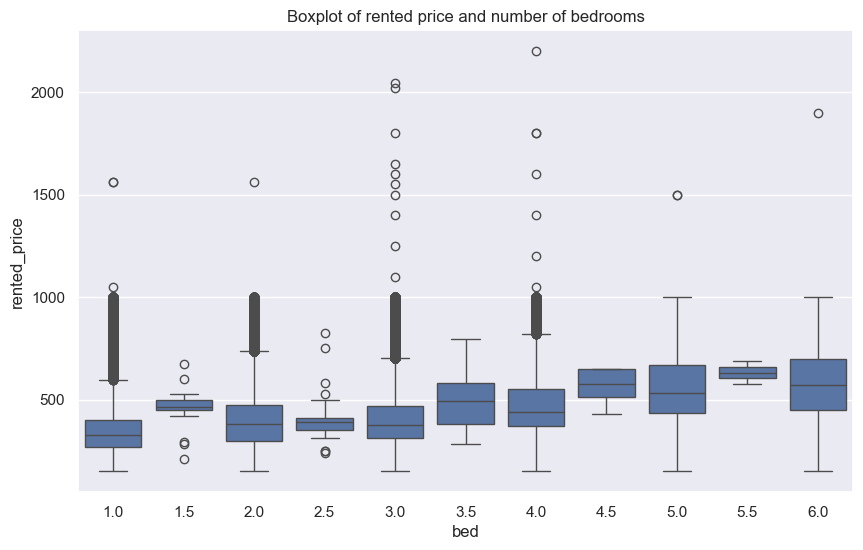

In [43]:
# plot a diagram comparing the rented price and the number of bedrooms
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.figure(figsize=(10,6))
sns.boxplot(x="bed",y="rented_price",data=rental_df)
plt.title("Boxplot of rented price and number of bedrooms")

In [45]:
# if a property has more than 4 bedrooms, then it's a house
rental_df.loc[rental_df["bed"]>4,"type"] = "House"

In [47]:
rental_df.to_csv("../data/raw/rental_data.csv",index=False)